# Frequency Distributions

See notes 20.021.Frequency_Distributions.md

In [225]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.core.display import HTML, display
from importlib import reload
import scipy.stats as ss

# pandas options 
pd.set_option('max_rows', 50)
pd.set_option('max_columns', 30)
pd.set_option('display.max_colwidth', 150)

# matplotlib and plotting options 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# seaborn options 
sns.set(context='paper', style='darkgrid', font='serif')
# sns.set(context='paper', style='ticks', font='serif')

# warnings
import warnings
# warnings.simplefilter('error')
# warnings.simplefilter('ignore')

# this file is in examples
import sys
sys.path.insert(0,'/s/telos/python/aggregate_project/')
import aggregate as agg

import aggregate.parser as parser
import aggregate.underwriter as trash
uw = trash.Underwriter(debug=False)
from aggregate.utils import sgamma_fit, MomentAggregator


In [226]:
ft = lambda x: np.fft.fft(x)

ift = lambda x : np.fft.ifft(x)

In [121]:
def gamma_mix(n, cv, skew_mult, log2, **kwds):
    
    def defuzz(x):
        x[np.abs(x) < 5e-16] = 0
        return x
    
    N = 1 << log2
    z = np.zeros(N)
    z[1] = 1
    fz = ft(z)
    # build poisson for comparison
    kernel = n * (fz - 1)
    p = np.real(ift(np.exp(kernel)))
    p = defuzz(p)
    
    # Var(G) = c, E(G)=1 so Var(G) = cv^2
    c = cv*cv
    # wikipedia / scipy stats use a and theta for shape and scale
    a = 1 / c
    θ = c
    nb = np.real(ift( (1 - θ * kernel) ** -a))
    nb = defuzz(nb)
    
    sh, a2, θ2 = sgamma_fit(1, cv, 2 * cv * skew_mult)
    # by hand gamma=target skewness
    γ = skew_mult * 2 * cv 
    a_ = 4 / (γ * γ)
    θ_ = cv * γ / 2
    sh_ = 1 - 2 * cv / γ
    print(f'{sh}={sh_}\t {a2}={a_}\t {θ2}={θ_}')
    
    delaporte = np.real(ift( np.exp(sh * kernel) *  (1 - θ2 * kernel) ** -a2))
    delaporte = defuzz(delaporte)
    
    df = pd.DataFrame(dict(x=range(N), poisson=p, negbin=nb, delaporte=delaporte))
    df.plot(kind='line', x='x', **kwds)

    # moments 
    moms = lambda col :  ((df.x**k * df[col]).sum() for k in (1,2,3))
    pm1, pm2, pm3 = moms('poisson') 
    pm, pcv, psk = MomentAggregator._moments_to_mcvsk(pm1, pm2, pm3)
    nbm1, nbm2, nbm3 = moms('negbin')
    nbm, nbcv, nbsk = MomentAggregator._moments_to_mcvsk(nbm1, nbm2, nbm3)
    dm1, dm2, dm3 = moms('delaporte')
    dm, dcv, dsk = MomentAggregator._moments_to_mcvsk(dm1, dm2, dm3)
    
    # asymptotic moments 
    asNCV = np.sqrt(1/n + c)
    asNSK = 2 * cv
    
    # direct calc of delaporte moments
    eg3 = 2 * skew_mult * cv**4 + 3*c + 1  # γ * c**(3/2) + 3 * c + 1
    eg2 = 1 + c
    en3 = n**3 * eg3  + 3 * n*n * eg2 + n   
    # this is central: n**3 * (γ + 3 * c - 1) + n * n * (3 * c + 2) + n 
    en2 = n*n*(1+c) + n
    en = n
    dirm, dircv, dirsk = MomentAggregator._moments_to_mcvsk(en, en2, en3)
    print(f'{dm}={dirm}\t{dcv}={dircv}\t{dsk}={dirsk}')
    
    temp = pd.DataFrame(dict(cv=cv, skew_mult=skew_mult, a=a, θ=θ, sh=sh, a2=a2, θ2=θ2, 
                             pm=pm, pcv=pcv, psk=psk,
                             nbm=nbm, nbcv=nbcv, nbsk=nbsk, asNCV=asNCV, asNSK=asNSK,
                            dm=dm, dcv=dcv, dsk=dsk), 
                         index=[1])
    temp = temp.set_index(['cv', 'skew_mult'])
    assert np.allclose([df[['poisson', 'negbin', 'delaporte']].sum()], 1)
    display(temp)
    return df, temp

0.5=0.5	 4.0=4.0	 0.125=0.125
24.99999999999906=25	0.3201562118714752=0.32015621187164245	0.7534431731911351=0.7534431732089336


,,a,θ,sh,a2,θ2,pm,pcv,psk,nbm,nbcv,nbsk,asNCV,asNSK,dm,dcv,dsk
cv,skew_mult,,,,,,,,,,,,,,,,
0.25,2,16.0,0.0625,0.5,4.0,0.125,25.0,0.2,0.2,25.0,0.320156,0.515373,0.320156,0.5,25.0,0.320156,0.753443


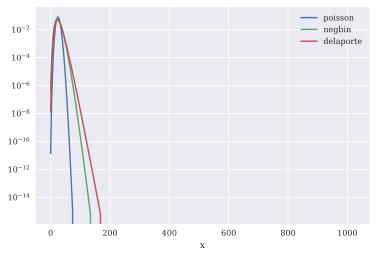

In [122]:
df, temp = gamma_mix(25, .25, 2, 10, logy=True)

In [381]:
def mixing(n, ν, f, cpo, log2, xmax=500, **kwds):
    """
    n = E(N) = expected claim count
    ν = CV(mixing) = asymptotic CV of any compound aggregate whose severity has a second moment
    f = proportion of certain claims, 0 <= f < 1, higher f corresponds to greater skewnesss
    cpo = claims per occurrence 
    """
    
    def defuzz(x):
        x[np.abs(x) < 5e-16] = 0
        return x
    
    ma = lambda x : list(MomentAggregator._moments_to_mcvsk(*x))
    
    def row(ps):
        moms = [(x**k * ps).sum() for k in (1,2,3)]
        stats = ma(moms)
        return moms + stats

    def Nmoms(n, c, g):
        """ 
        c=Var(G), g=E(G^3) return EN, EN2, EN3 
        """
        return [n, n * (1 + (1 + c) * n), n * (1 + n * (3*(1+c) + n * g))]
    
    ans = pd.DataFrame(columns=['X', 'type', 'EX', 'EX2', 'EX3', 'mean', 'CV', 'Skew'])
    ans = ans.set_index(['X', 'type'])

    N = 1 << log2
    x = np.arange(N, dtype=float)
    z = np.zeros(N)
    z[1] = 1
    fz = ft(z)
    
    # contagion
    c = ν * ν
    
    # build poisson for comparison
    dist = 'poisson'
    kernel = n * (fz - 1)
    p = np.real(ift(np.exp(kernel)))
    p = defuzz(p)

    # for poisson c=0 and g=1 (the "mixing" distribution is G identically equal to 1)
    ans.loc[(dist, 'empirical'), :] = row(p)
    temp = Nmoms(n, 0, 1)
    ans.loc[(dist, 'theoretical'), :] = temp + ma(temp)
    ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1
    
    # negative binomial
    # Var(G) = c, E(G)=1 so Var(G) = ν^2 = c
#     wikipedia / scipy stats use a and θ for shape and scale
    dist = 'neg bin'
    a = 1 / c
    θ = c
    # E(G^3): skew(G) = skew(G') = γ, so E(G-EG)^3 = γν^3, so EG^3 = γν^3 + 3(1+c) - 2 = γν^3 + 3c + 1
    # for Gamma skew = 2 / sqrt(a) = 2ν, so g = 2ν^4 = 2 c^2
    g = 1 + 3*c + 2*c*c
    nb = np.real(ift( (1 - θ * kernel) ** -a))
    nb = defuzz(nb)
    
    ans.loc[(dist, 'empirical'), :] = row(nb)
    # this row is generic: it applies to all distributions 
    temp = Nmoms(n, c, g)   # [n, n * (1 + (1 + c) * n), n*(1 + n * (3*(1+c) + n * g))] # n**3*g + 3*n**2*(1+c)+n]
    ans.loc[(dist, 'theoretical'), :] = temp + ma(temp)
    ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1
        
    # delaporte G = f + G'
    dist = 'delaporte'
    a = ((1 - f) / ν)**2
    θ = (1 - f) / a
    g = 2 * ν**4 / (1-f) + 3 * c + 1
    delaporte = np.real(ift( np.exp(f * kernel) *  (1 - θ * kernel) ** -a))
    delaporte = defuzz(delaporte)
    
    ans.loc[(dist, 'empirical'), :] = row(delaporte)
    temp = Nmoms(n, c, g)
    ans.loc[(dist, 'theoretical'), :] = temp + ma(temp)
    ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1

    # pig
    dist = 'pig'
    μ = c
    λ = 1 / μ
    # our param (λ, μ) --> (λ, λμ) in Mathematica and hence skew = γ = 3 * sqrt(μ) in scip py parameterization 
    γ = 3 * np.sqrt(μ) 
    g = γ * ν**3 + 3 * c + 1
    pig = np.real(ift( np.exp( 1/μ * (1 - np.sqrt(1 - 2 * μ**2 * λ * kernel)) )))
    pig = defuzz(pig)
    
    ans.loc[(dist, 'empirical'), :] = row(pig)
    temp = Nmoms(n, c, g)
    ans.loc[(dist, 'theoretical'), :] = temp + ma(temp)
    ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1

    # shifted pig
    dist = 'shifted pig'
    μ = c / (1 - f)**2 
    λ = (1 - f) / μ
    γ = 3 * np.sqrt(μ) 
    g = γ * ν**3 + 3 * c + 1
    shifted_pig = np.real(ift(  np.exp(f * kernel) * np.exp( 1/μ * (1 - np.sqrt(1 - 2 * μ**2 * λ * kernel)))))
    shifted_pig = defuzz(shifted_pig)
    
    ans.loc[(dist, 'empirical'), :] = row(shifted_pig)
    temp = Nmoms(n, c, g)
    ans.loc[(dist, 'theoretical'), :] = temp + ma(temp)
    ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1
    
    #  poisson pascal 
    dist = 'poisson pascal'
    a = 1 / c
    θ = cpo * c
    λ = n / cpo
    g = 1
    pois_pascal = np.real(ift( np.exp(λ * ((1 - θ * fz)**-a - 1))))
    pois_pascal = defuzz(pois_pascal)
    
    ans.loc[(dist, 'empirical'), :] = row(pois_pascal)
    temp = Nmoms(n, c, g)
    ans.loc[(dist, 'theoretical'), :] = temp + ma(temp)
    ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1
    
    
    # sum of all errors is small 
    print( ans.loc[(slice(None), 'diff'), :].abs().sum().sum() )
#     assert ans.loc[(slice(None), 'diff'), :].abs().sum().sum() 
    
    # graphic 
    df = pd.DataFrame(dict(x=x, poisson=p, negbin=nb, delaporte=delaporte, pig=pig, shifted_pig=shifted_pig, pois_pascal=pois_pascal))
    df = df.query(f' x < {xmax} ')
    f, ax = plt.subplots(1,2,figsize=(11,5))    
    df.plot(kind='line', x='x', ax=ax[0], **kwds)
    ax[0].set_xlim(0, 4*n)
    df.plot(kind='line', x='x', logy=True, ax=ax[1], **kwds)

    # asymptotic moments 
#     asNCV = np.sqrt(c)
#     asNSK = 2 * cv
#     delSK = 2 / np.sqrt(a)
   
    display(ans)
    return df, ans

129092.314841


EX          EX2          EX3  \
X              type                                                 
poisson        empirical             50         2550       132550   
               theoretical           50         2550       132550   
               diff        -1.64313e-14 -3.41949e-14 -6.19504e-14   
neg bin        empirical             50         3175       243800   
               theoretical           50         3175       243800   
               diff         -1.5532e-13 -1.04039e-12 -6.64746e-12   
delaporte      empirical             50         3175       290675   
               theoretical           50         3175       290675   
               diff        -8.91842e-13 -1.86359e-11 -2.90952e-10   
pig            empirical             50         3175       251612   
               theoretical           50         3175       251612   
               diff        -3.03868e-13 -3.18712e-12 -3.01278e-11   
shifted pig    empirical             50         3175       321925   
               theoretical           50         3175       321925   
               diff        -2.63856e-12 -9.78995e-11  -2.3685e-09   
poisson pascal empirical           2500     6.44e+06  1.70674e+10   
               theoretical           50         3175       134425   
               diff                  49      2027.35       126965   

                                   mean           CV         Skew  
X              type                                                
poisson        empirical             50     0.141421     0.141421  
               theoretical           50     0.141421     0.141421  
               diff        -1.64313e-14 -3.35287e-14 -2.37149e-11  
neg bin        empirical             50     0.519615      1.00074  
               theoretical           50     0.519615      1.00074  
               diff         -1.5532e-13  -1.7164e-12 -6.09177e-11  
delaporte      empirical             50     0.519615      3.67366  
               theoretical           50     0.519615      3.67366  
               diff        -8.91842e-13  -3.9634e-11 -1.05718e-09  
pig            empirical             50     0.519615      1.44623  
               theoretical           50     0.519615      1.44623  
               diff        -3.03868e-13 -6.06648e-12 -2.23209e-10  
shifted pig    empirical             50     0.519615       5.4556  
               theoretical           50     0.519615       5.4556  
               diff        -2.63856e-12 -2.17834e-10 -6.82828e-09  
poisson pascal empirical           2500     0.174356     0.210579  
               theoretical           50     0.519615     -5.23607  
               diff                  49    -0.664452     -1.04022

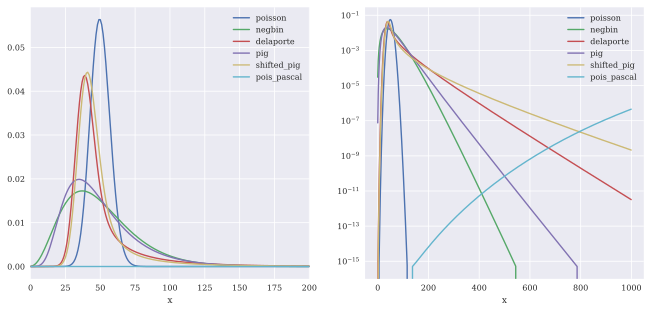

In [382]:
mixing(50, .5, 0.75, 1.2, 15, xmax=1000);

In [306]:
df

EX          EX2          EX3         mean  \
X         type                                                              
poisson   empirical             50         2550       132550           50   
          theoretical           50         2550       132550           50   
          diff        -1.84297e-14 -3.59712e-14 -6.32827e-14 -1.84297e-14   
neg bin   empirical             50         8175   2.2588e+06           50   
          theoretical           50         8175   2.2588e+06           50   
          diff        -4.03677e-12 -7.69211e-11 -8.97642e-10 -4.03677e-12   
delaporte empirical             50         8175  3.52442e+06           50   
          theoretical           50         8175  3.52442e+06           50   
          diff        -1.29464e-11 -4.53622e-10  -6.1321e-09 -1.29464e-11   

                                CV         Skew  
X         type                                   
poisson   empirical       0.141421     0.141421  
          theoretical     0.141421     0.141421  
          diff         2.28706e-14 -2.67893e-11  
neg bin   empirical        1.50665      3.00003  
          theoretical      1.50665      3.00003  
          diff        -4.95886e-11 -1.34499e-09  
delaporte empirical        1.50665      5.96047  
          theoretical      1.50665      5.96047  
          diff        -3.08078e-10 -7.29763e-09

In [297]:
df.loc[(slice(None), 'diff'), :].abs().sum().sum()

1.6621486520485007e-08

In [254]:
    ans = pd.DataFrame(columns=['X', 'type', 'EX', 'EX2', 'EX3', 'mean', 'CV', 'Skew'])
    ans = ans.set_index(['X', 'type'])

In [256]:
ans.loc[(1,2), :] = list(range(6))

In [257]:
ans

,,EX,EX2,EX3,mean,CV,Skew
X,type,,,,,,
1,2,0,1,2,3,4,5


3.25 2.5
formula 4.7407407407407405 vs. 3.0
Thy 2016925.0 vs. emp 821090.7435865849, diff 1195834.256413415


,,a,θ,shift,pm,pcv,psk,nbm,nbcv,nbsk,asNCV,asNSK,delSK,dm,dcv,dsk
cv,certain,,,,,,,,,,,,,,,
1.5,0.5,0.111111,4.5,0.5,50.0,0.141421,0.141421,48.906392,1.445487,2.484275,1.5,3.0,6.0,47.16335,1.249756,4.009605


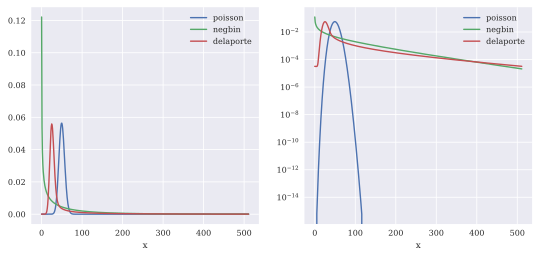

In [236]:
a, b = gamma_mix(50, 1.5, .5, 9)

In [189]:
def pig_mix(n, cv, certain, log2, **kwds):
    
    def defuzz(x):
        x[np.abs(x) < 5e-16] = 0
        return x
    
    N = 1 << log2
    z = np.zeros(N)
    z[1] = 1
    fz = ft(z)
    
    # build poisson for comparison
    kernel = n * (fz - 1)
    p = np.real(ift(np.exp(kernel)))
    p = defuzz(p)
    
    # Var(G) = c, E(G)=1 so Var(G) = cv^2
    c = cv*cv
    # wikipedia / scipy stats use a and theta for shape and scale
    μ = cv*cv
    λ = 1/μ
    fz = ss.invgauss(μ, scale=λ)
    print(fz.stats('mvs'))
    
    # not correct... 
    pig = np.real(ift( np.exp(λ / μ * (1 - np.sqrt(1 - 2 * μ**2 * kernel / λ) ))))  
    pig = defuzz(pig)
    
    shift = certain
    a = ((1 - shift) / cv)**2
    θ = (1 - shift) / a
   
    delaporte = np.real(ift( np.exp(shift * kernel) *  (1 - θ * kernel) ** -a))
    delaporte = defuzz(delaporte)
    
    df = pd.DataFrame(dict(x=range(N), poisson=p, pig=pig, delaporte=delaporte))
    f, ax = plt.subplots(1,2,figsize=(9,4))
    
    df.plot(kind='line', x='x', ax=ax[0], **kwds)
    df.plot(kind='line', x='x', logy=True, ax=ax[1], **kwds)

    # numerical moments 
    moms = lambda col :  ((df.x**k * df[col]).sum() for k in (1,2,3))
    pm1, pm2, pm3 = moms('poisson') 
    pm, pcv, psk = MomentAggregator._moments_to_mcvsk(pm1, pm2, pm3)
    pigm1, pigm2, pigm3 = moms('pig')
    pigm, pigcv, pigsk = MomentAggregator._moments_to_mcvsk(pigm1, pigm2, pigm3)
    dm1, dm2, dm3 = moms('delaporte')
    dm, dcv, dsk = MomentAggregator._moments_to_mcvsk(dm1, dm2, dm3)
    
    # asymptotic moments 
    asNCV = np.sqrt(c)
    asNSK = 2 * cv
    delSK = 2 / np.sqrt(a)
   
    temp = pd.DataFrame(dict(cv=cv, certain=certain, a=a, θ=θ, shift=shift,   
                             pm=pm, pcv=pcv, psk=psk,
                             pigm=pigm, pigcv=pigcv, pigsk=pigsk, 
                             asNCV=asNCV, asNSK=asNSK, delSK=delSK,
                             dm=dm, dcv=dcv, dsk=dsk), 
                         index=[1])
    temp = temp.set_index(['cv', 'certain'])
    assert np.allclose([df[['poisson', 'pig', 'delaporte']].sum()], 1)
    display(temp)
    return df, temp

(array(1.0), array(0.0625), array(0.75))


,,a,θ,shift,pm,pcv,psk,pigm,pigcv,pigsk,asNCV,asNSK,delSK,dm,dcv,dsk
cv,certain,,,,,,,,,,,,,,,
0.25,0.5,4.0,0.125,0.5,50.0,0.141421,0.141421,3.125,0.569128,0.576074,0.25,0.5,1.0,50.0,0.287228,0.834518


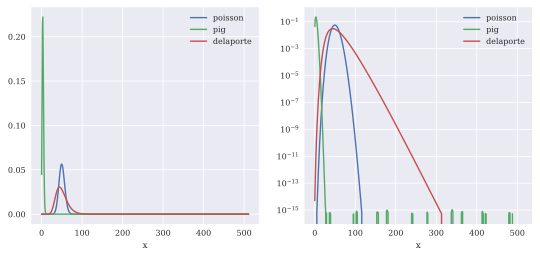

In [190]:
a, b = pig_mix(50, 0.25, .5, 9)

In [367]:
from scipy.special import kv

def sichel(α, β, γ, log2, **kwds):
    N = 1<<log2
    z = np.zeros(N)
    z[1] = 1
    fz = ft(z)
    ξ = β / np.sqrt(1 - 2*β/α)
    ω = np.sqrt(ξ*ξ + α*α) - ξ
    kgo = kv(γ, ω)
    rad = np.sqrt(1-2*β*(fz-1))
    mean = ξ*kv(γ+1, ω)/kgo
    print(rad)
    p = np.real(ift(np.exp(mean * (fz-1))))
    sichel = np.real(ift( kv(γ, ω*rad) / (kgo * rad**γ) ))
#     print(kv(γ, ω*rad))
    df = pd.DataFrame(dict(x=range(N), poisson=p, sichel=sichel))
    df.plot(kind='line', x='x', **kwds)
    pm, pm2, pm3 = ((df.x**k * df.poisson).sum() for k in (1,2,3))
    sichelm, sichelm2, sichelm3 = ((df.x**k * df.sichel).sum() for k in (1,2,3))
    pv = pm2 - pm*pm
    sichelv = sichelm2 - sichelm*sichelm
    display(pd.DataFrame(dict(α=α, β=β, γ=γ, ξ=ξ, ω=ω, pm=pm, pv=pv, sichelm=sichelm, sichelv=sichelv, cv=np.sqrt(sichelv) / sichelm), index=['Sample']))
    return df

In [ ]:
sichel(10, 8, -0.5, 8)

In [369]:
def pois_pas(claims, claimants_per_claim, cv_claimants, log2, **kwds):
    N = 1<<log2
    z = np.zeros(N)
    z[1] = 1
    fz = ft(z)
    c2 = cv_claimants*cv_claimants
    k = 1/c2
    P = claimants_per_claim * c2
    θ = claims / claimants_per_claim
    p = np.real(ift(np.exp(claims * (fz-1))))  
#     nb = np.real(ift( (1+P-P*fz)**-k ))
    pois_pas = np.real(ift( np.exp(θ*((1+P-P*fz)**-k - 1))))
    df = pd.DataFrame(dict(x=range(N), poisson=p, pois_pas=pois_pas))
    df.plot(kind='line', x='x', **kwds)
    pm, pm2, pm3 = ((df.x**k * df.poisson).sum() for k in (1,2,3))
    pois_pasm, pois_pasm2, pois_pasm3 = ((df.x**k * df.pois_pas).sum() for k in (1,2,3))
    pv = pm2 - pm*pm
    pois_pasv = pois_pasm2 - pois_pasm*pois_pasm
    display(pd.DataFrame(dict(mean=claims, claimants=claimants_per_claim, cv_claimants=cv_claimants, k=k, P=P, θ=θ, pm=pm, pv=pv, pois_pasm=pois_pasm, pois_pasv=pois_pasv, cvest=np.sqrt(pois_pasv) / pois_pasm), index=['Sample']))
    return df

,mean,claimants,cv_claimants,k,P,θ,pm,pv,pois_pasm,pois_pasv,cvest
Sample,10,1.1,2,0.25,4.4,9.090909,10.0,10.0,10.0,65.0,0.806226


,mean,claimants,cv_claimants,k,P,θ,pm,pv,pois_pasm,pois_pasv,cvest
Sample,10,0.55,2.1,0.226757,2.4255,18.181818,10.0,10.0,10.0,39.755,0.630516


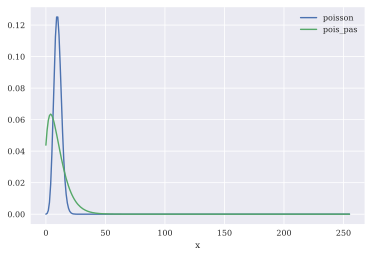

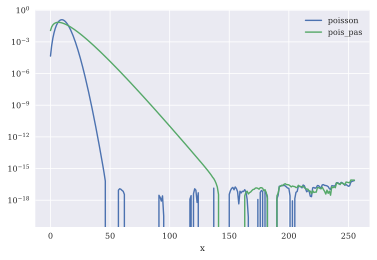

In [370]:
df = pois_pas(10, 1.1, 2, 8)

df = pois_pas(10, .55, 2.1, 8, logy=True)